In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import matplotlib.patches as mpatches


import cv2

### Dataset

In [79]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("roshan81/ageutk")

# print("Path to dataset files:", path)

# /Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6

In [80]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

# print("Path to dataset files:", path)


# /Users/hidde/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1

## Load in Data

In [81]:
# /Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6
# path = '/Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6/UTKFace/UTKFace/UTKFace/10_0_1_20170110220507258.jpg.chip.jpg'
path = "/Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6/ageutk_full.csv"

data = pd.read_csv(path)
data.head()

,files,age,gender
0,26_0_2_20170104023102422.jpg.chip.jpg,26,0
1,22_1_1_20170112233644761.jpg.chip.jpg,22,1
2,21_1_3_20170105003215901.jpg.chip.jpg,21,1
3,28_0_0_20170117180555824.jpg.chip.jpg,28,0
4,17_1_4_20170103222931966.jpg.chip.jpg,17,1


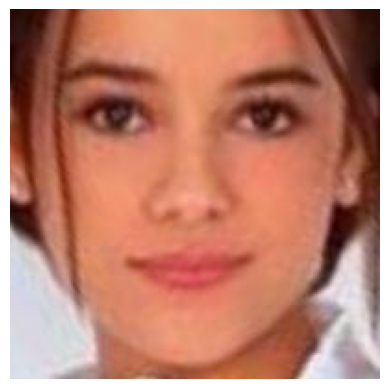

In [82]:
i = 10
path = '/Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6/UTKFace/UTKFace/UTKFace/' + data["files"][i]
image = cv2.imread(path)
# plt.imshow(image)

# Converteer de afbeelding van BGR naar RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Toon de afbeelding met matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Verberg de assen
plt.show()


In [83]:
data["age"].min() ,data["age"].max()

(np.int64(1), np.int64(80))

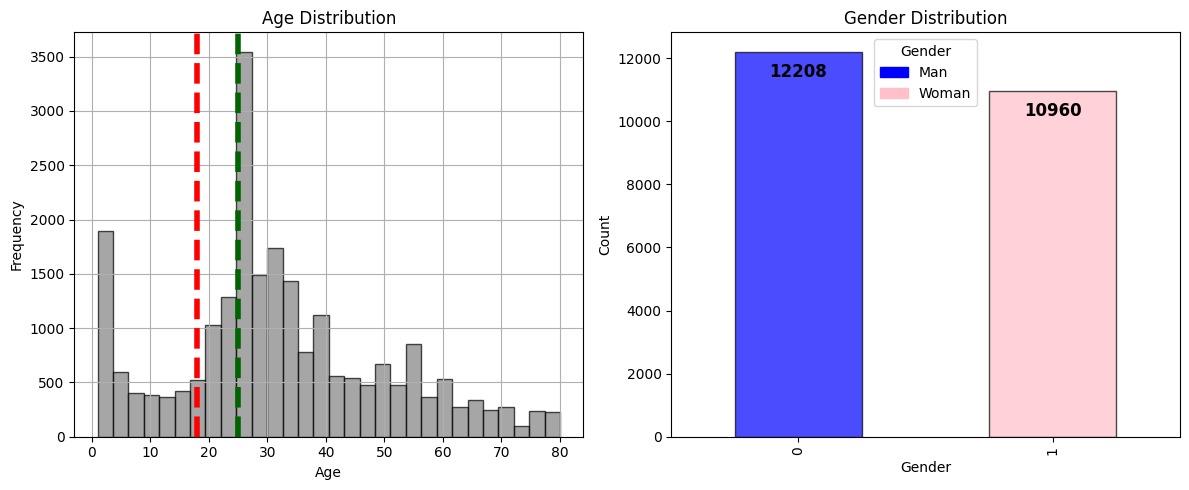

In [84]:
# Creëer de figuur en assen voor 2 plots naast elkaar
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Leeftijdsverdeling histogram
axes[0].hist(data['age'], bins=30, color='grey', alpha=0.7, edgecolor='black')
axes[0].axvline(x=18, color='red', linestyle='dashed', linewidth=4)  # Verticale rode stippellijn op 25
axes[0].axvline(x=25, color='darkgreen', linestyle='dashed', linewidth=4)  # Verticale rode stippellijn op 25

axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution')
axes[0].grid()

# Plot 2: Genderverdeling histogram
gender_counts = data['gender'].value_counts()
gender_counts.plot(kind='bar', ax=axes[1], color=['blue', 'pink'], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')
axes[1].set_title('Gender Distribution')
# Handmatige legenda maken
legend_patches = [
    mpatches.Patch(color='blue', label='Man'),
    mpatches.Patch(color='pink', label='Woman')
]
axes[1].legend(handles=legend_patches, title="Gender", loc='upper center')


# Totaal boven de boxen plaatsen
for i, v in enumerate(gender_counts):
    axes[1].text(i, v - 800, str(v), ha='center', fontsize=12, fontweight='bold')  # Plaats het aantal boven de boxen

# Toon de figuur
plt.tight_layout()
plt.show()



In [85]:
print("Data < 18: \t", data[data["age"] < 18].shape[0])
print("18 < Data < 25: ", data[(data["age"] > 18) & (data["age"] < 25)].shape[0])
print("Data > 25: \t", data[data["age"] > 25].shape[0])
print("Data < 25: \t", data[data["age"] < 25].shape[0])

Data < 18: 	 4233
18 < Data < 25:  2408
Data > 25: 	 15531
Data < 25: 	 6903


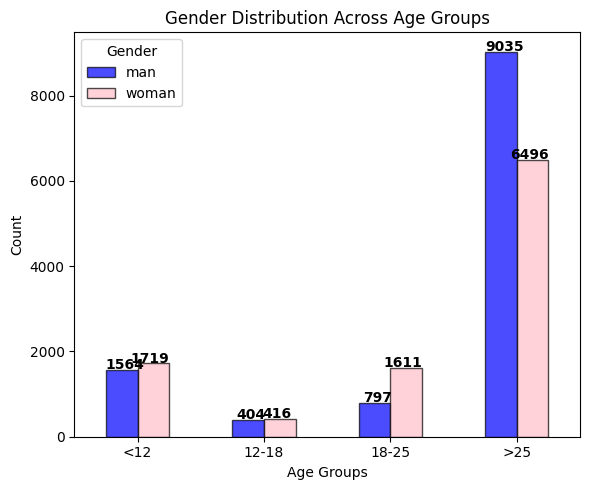

In [86]:

# Groepeer de data in de drie leeftijdscategorieën en tel het aantal mannen en vrouwen per groep
age_groups = {
    '<12': data[data["age"] < 12]['gender'].value_counts(),
    '12-18': data[(data["age"] > 12) & (data["age"] < 18)]['gender'].value_counts(),
    '18-25': data[(data["age"] > 18) & (data["age"] < 25)]['gender'].value_counts(),
    '>25': data[data["age"] > 25]['gender'].value_counts()
}

# Zet de data in een dataframe voor makkelijker plotten
age_group_df = pd.DataFrame(age_groups).T.fillna(0)  # Vul missende waarden (geen Male/Female in een categorie) met 0

# Plot de gegevens als een gegroepeerde bar chart
fig, ax = plt.subplots(figsize=(6, 5))
age_group_df.plot(kind='bar', ax=ax, color=['blue', 'pink'], alpha=0.7, edgecolor='black')

# Labels en titel instellen
ax.set_xlabel('Age Groups')
ax.set_ylabel('Count')
ax.set_title('Gender Distribution Across Age Groups')
ax.legend(title='Gender', labels=["man", "woman"])

# Totaal boven de boxen plaatsen
for age_idx, (age_group, values) in enumerate(age_group_df.iterrows()):
    for gender_idx, value in enumerate(values):
        ax.text(age_idx + gender_idx * 0.2 - 0.1, value + 15, str(int(value)), ha='center', fontsize=10, fontweight='bold')

plt.xticks(rotation=0)  # Zorgt ervoor dat de leeftijdsgroepen horizontaal blijven staan
plt.tight_layout()
plt.show()


Zou het kunnen om 2 verschillende datasets [gender, age] en [emotion] te kunnen gebruiken om in een nieuwe dataset alle 2 te kunnen voorspellen? En wat zijn de limitaties van de niet-overeenkomstige datasets?

# Emotion Dataset

In [87]:
# /Users/hidde/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1


from pathlib import Path

# Lokale paden (pas deze aan naar waar jij de datasets hebt opgeslagen)
EMOTION_IMAGE_PATH = Path("/Users/hidde/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/")
AGEUTK = Path("/Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6")

# Check of de mappen bestaan
print("Bestaat EMOTION_IMAGE_PATH?:", EMOTION_IMAGE_PATH.exists())
print("Bestaat AGEUTK?:", AGEUTK.exists())

# Haal lijst van afbeeldingen op
EMOTION_TRAIN_PATH = EMOTION_IMAGE_PATH / "train"
EMOTION_TEST_PATH = EMOTION_IMAGE_PATH / "test"

TRAIN_EMOTION_IMAGE_PATH_LIST = list(EMOTION_TRAIN_PATH.glob('*/*.png'))
TEST_EMOTION_IMAGE_PATH_LIST = list(EMOTION_TEST_PATH.glob('*/*.png'))

AGEUTK_PATH_LIST = list((AGEUTK / 'UTKFace').glob("*/*/*.jpg.chip.jpg"))

print("Aantal EMOTION TRAIN afbeeldingen:", len(TRAIN_EMOTION_IMAGE_PATH_LIST))
print("Aantal AGEUTK afbeeldingen:", len(AGEUTK_PATH_LIST))


Bestaat EMOTION_IMAGE_PATH?: True
Bestaat AGEUTK?: True
Aantal EMOTION TRAIN afbeeldingen: 28709
Aantal AGEUTK afbeeldingen: 23707


In [119]:
train_emotion_data = [{'path': path, 'emotion': path.parent.stem} for path in TRAIN_EMOTION_IMAGE_PATH_LIST]# if path.parent.stem != 'disgusted' and path.parent.stem != 'fearful']
test_emotion_data = [{'path': path, 'emotion': path.parent.stem} for path in TEST_EMOTION_IMAGE_PATH_LIST]# if path.parent.stem != 'disgusted' and path.parent.stem != 'fearful']

train_emotion= pd.DataFrame(train_emotion_data)
test_emotion= pd.DataFrame(test_emotion_data)

train_emotion

,path,emotion
0,/Users/hidde/.cache/kagglehub/datasets/ananthu...,happy
1,/Users/hidde/.cache/kagglehub/datasets/ananthu...,happy
2,/Users/hidde/.cache/kagglehub/datasets/ananthu...,happy
3,/Users/hidde/.cache/kagglehub/datasets/ananthu...,happy
4,/Users/hidde/.cache/kagglehub/datasets/ananthu...,happy
...,...,...
28704,/Users/hidde/.cache/kagglehub/datasets/ananthu...,surprised
28705,/Users/hidde/.cache/kagglehub/datasets/ananthu...,surprised
28706,/Users/hidde/.cache/kagglehub/datasets/ananthu...,surprised
28707,/Users/hidde/.cache/kagglehub/datasets/ananthu...,surprised


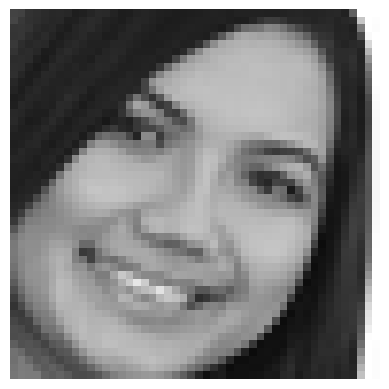

In [110]:
image = cv2.imread(train_emotion['path'][3])
# plt.imshow(image)

# Converteer de afbeelding van BGR naar RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Toon de afbeelding met matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Verberg de assen
plt.show()

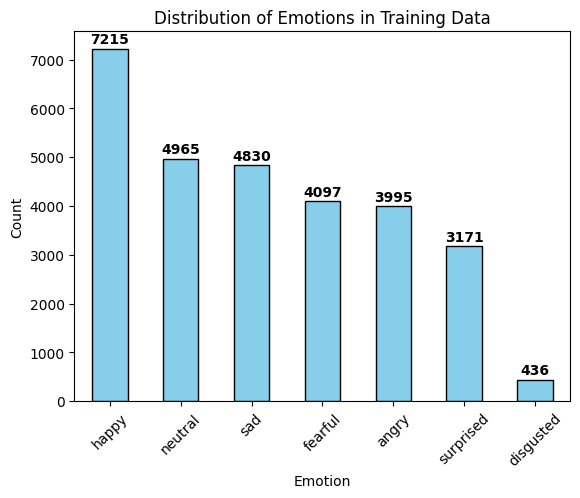

In [114]:
# train_emotion["emotion"].value_counts()

train_emotion['emotion'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Emotion')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Distribution of Emotions in Training Data')

# Place the total above the bars
emotion_counts = train_emotion['emotion'].value_counts()
for i, count in enumerate(emotion_counts):
    plt.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

In [ ]:
# def parse_filename(filename):
#     parts = filename.split("_")
#     return {"path": f"/Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6/UTKFace/UTKFace/UTKFace/{filename}", "age": int(parts[0]), "gender": int(parts[1])}

In [ ]:
# ageutkface_data = [parse_filename(path.name) for path in AGEUTK_PATH_LIST]
# ageutkface_metadata = pd.DataFrame(ageutkface_data)

In [100]:

# # ageutkface_metadata["path"][0]


# image = cv2.imread(ageutkface_metadata["path"][10])
# # plt.imshow(image)

# # Converteer de afbeelding van BGR naar RGB
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Toon de afbeelding met matplotlib
# plt.imshow(image_rgb)
# plt.axis('off')  # Verberg de assen
# plt.show()


# # ageutkface_metadata[["age", "emotion"]][1]